In [1]:
import os
import sys
import bz2
import json
import mpld3
import pandas as pd
import _pickle as cPickle
import svgutils.transform as sg
import matplotlib.pyplot as plt

from jazzy import core
from rdkit import Chem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from sklearn.metrics import mean_absolute_error, r2_score
# from mpld3 import plugins
# mpld3.enable_notebook()

In [2]:
# Import config
opt_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'optimisation'))
sys.path.insert(0, opt_path)
import config

# Open the parameters
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', config.DATA_PATH))
optuna_path = os.path.join(data_path, config.OPTUNA_DIRNAME)
params_filepath = os.path.join(optuna_path, config.OPTUNA_DELTAG_PARAMETERS_FILENAME)
with open(params_filepath) as f:
    best_params = json.load(f)
best_params

/home/kdxr003/.cache/pypoetry/virtualenvs/jazzy-ZuwbZvu4-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'gd': -0.9076664181509553,
 'ga': -16.13143317348325,
 'g0': 1.8842791231644282,
 'gs': 0.046698073586512054,
 'gr': -3.6429426011852524,
 'gpi1': -1.6022604035599135,
 'gpi2': -1.1740853831959548,
 'gi': 4.999560447432514,
 'F': 0.5143359987215719,
 'expd': 0.5041243951898653,
 'expa': 0.3436880638589098}

In [3]:
# Select parameters
gd = best_params['gd']              # gd=-139.0
ga = best_params['ga']              # ga=-32.0
g0 = best_params['g0']              # g0=5.53
gs = best_params['gs']              # gs=0.031
gr = best_params['gr']              # gr=-4.39
gpi1 = best_params['gpi1']          # gpi1=-1.82
gpi2 = best_params['gpi2']          # gpi2=-1.29   
gi = best_params['gi']              # gi=37.2
f = best_params['F']                # f=0.325
expd = best_params['expd']          # expd=0.68
expa = best_params['expa']          # expa=0.51

In [4]:
def moltosvg(mol, molSize=(100,100), kekulize=True, label=None):
    """Produces the rendering of an input RDKit molecule.
    """
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    s = svg.replace('svg:','')
    if label is not None:
        fig = sg.fromstring(s)
        label = sg.TextElement(80, 80, label, size=12, 
                        font='sans-serif', anchor='middle', color='#000000')
        fig.append(label)
        s = fig.to_str().decode("utf-8") 
    return s

In [5]:
def calculate_deltag(rdkit_mol, atomic_map, atoms_and_nbrs):
    """Calculate individual terms and return their sum
    """
    dgp = round(core.calculate_delta_polar(atomic_map, 
                                           atoms_and_nbrs, 
                                           gd=gd, 
                                           ga=ga,
                                           expd=expd,
                                           expa=expa), 
                                           4)

    dga = round(core.calculate_delta_apolar(rdkit_mol, 
                                            atomic_map,
                                            g0=g0,
                                            gs=gs,
                                            gr=gr,
                                            gpi1=gpi1,
                                            gpi2=gpi2),
                                            4)

    dgi = round(core.calculate_delta_interaction(rdkit_mol, 
                                                 atomic_map,
                                                 atoms_and_nbrs,
                                                 gi=gi,
                                                 expa=expa, 
                                                 f=f),
                                                 4)
    calc_deltag = dgp + dga + dgi
    return(calc_deltag)

In [6]:
def kcal_to_kj(v):
    """Conversion from kCal to kJ
    """
    return v*4.184

In [7]:
# Read data
guthrie_filepath = os.path.join(data_path, "free_energy_guthrie", "02-guthrie_curated.csv")
fields = ["mol", "Name", "value1", "error1", "dimension1"]
df = pd.read_csv(guthrie_filepath, usecols=fields)
df

,mol,Name,value1,error1,dimension1
0,CC(C)(C)C,"2,2-dimethylpropane",6.78,1.93,kcal/mol
1,CC(C)C,2-methylpropane,6.59,1.93,kcal/mol
2,C(CC)(CC)(CC)CC,"3,3-diethylpentane",6.50,1.93,kcal/mol
3,[Ar],Argon,6.27,1.93,kcal/mol
4,CCCC,butane,6.35,1.93,kcal/mol
...,...,...,...,...,...
3311,CSCC,thiomethoxyethane,-1.49,1.93,kcal/mol
3312,CSCC,thiomethoxyethane,-1.49,1.93,kcal/mol
3313,c1ccccc1C,toluene,-0.90,1.93,kcal/mol
3314,c1ccccc1C,toluene,-0.90,1.93,kcal/mol


In [8]:
# Determine what dimensions are available in the data set
set(df["dimension1"])

{'kCal/mol', 'kJ/mol', 'kcal/mol'}

In [9]:
# Determine range of errors and average error in the data set
df["error1"].min(), df["error1"].max(), df["error1"].mean(), 

(0.0026, 10.0, 2.581170172549457)

In [10]:
y_exp = []
y_calc = []
smiles = []
svgs = []

for idx, row in df.iterrows():
    try:
        rdkit_mol = core.rdkit_molecule_from_smiles(row["mol"], minimisation_method=config.MINIMISATION_METHOD)
        kallisto_mol = core.kallisto_molecule_from_rdkit_molecule(rdkit_mol)
        atoms_and_nbrs = core.get_covalent_atom_idxs(rdkit_mol)
        charges = core.get_charges_from_kallisto_molecule(kallisto_mol, charge=0)

        # Calculate polar strength map and energy of hydration
        atomic_map = core.calculate_polar_strength_map(rdkit_mol, kallisto_mol, atoms_and_nbrs, charges)
        y_calc.append(calculate_deltag(rdkit_mol, atomic_map, atoms_and_nbrs))

        # Get the appropriate experimental value
        y_exp.append(float(row["value1"]) if row["dimension1"] == "kJ/mol" else kcal_to_kj(float(row["value1"])))

        # Append SMILES and SVG, if nothing fails
        smiles.append(row["mol"])
        svgs.append(moltosvg(Chem.MolFromSmiles(row["mol"]), label=str(idx)))

    except (KeyError, AttributeError, TypeError) as e:
        print(e)
        print(row["mol"])
        continue

assert len(y_calc) == len(y_exp), "Something has not worked as expected..."
assert len(y_calc) == len(smiles), "Something has not worked as expected..."
assert len(y_calc) == len(svgs), "Something has not worked as expected..."

[11:26:50] UFFTYPER: Unrecognized atom type: Ar3 (0)
RDKit ERROR: [11:26:50] UFFTYPER: Unrecognized atom type: Ar3 (0)
[11:26:50] UFFTYPER: Unrecognized atom type: He (0)
RDKit ERROR: [11:26:50] UFFTYPER: Unrecognized atom type: He (0)
[11:26:50] UFFTYPER: Unrecognized atom type: Kr3 (0)
RDKit ERROR: [11:26:50] UFFTYPER: Unrecognized atom type: Kr3 (0)
[11:26:50] UFFTYPER: Unrecognized atom type: Ne3 (0)
RDKit ERROR: [11:26:50] UFFTYPER: Unrecognized atom type: Ne3 (0)
[11:26:50] UFFTYPER: Unrecognized atom type: Rn3 (0)
RDKit ERROR: [11:26:50] UFFTYPER: Unrecognized atom type: Rn3 (0)
[11:26:50] UFFTYPER: Unrecognized atom type: S_6+6 (0)
RDKit ERROR: [11:26:50] UFFTYPER: Unrecognized atom type: S_6+6 (0)
Jazzy ERROR: [11:26:50] The RDKit embedding has failed for the molecule: S(F)(F)(F)(F)(F)F
[11:26:50] UFFTYPER: Unrecognized atom type: Xe3 (0)
RDKit ERROR: [11:26:50] UFFTYPER: Unrecognized atom type: Xe3 (0)


'NoneType' object has no attribute 'HasProp'
S(F)(F)(F)(F)(F)F


RDKit ERROR: [11:28:31] Explicit valence for atom # 1 Cl, 4, is greater than permitted
[11:28:31] Explicit valence for atom # 1 Cl, 4, is greater than permitted
Jazzy ERROR: [11:28:31] The RDKit SMILES parsing has failed for the molecule: O=Cl=O


'NoneType' object has no attribute 'HasProp'
O=Cl=O


[11:28:33] UFFTYPER: Unrecognized atom type: S_6+6 (0)
RDKit ERROR: [11:28:33] UFFTYPER: Unrecognized atom type: S_6+6 (0)
Jazzy ERROR: [11:28:33] The RDKit embedding has failed for the molecule: S(F)(F)(F)(F)(F)F


'NoneType' object has no attribute 'HasProp'
S(F)(F)(F)(F)(F)F


In [13]:
len(y_calc)

3313

In [11]:
print("Jazzy predictions vs. experimental data:", r2_score(y_exp, y_calc), mean_absolute_error(y_exp, y_calc))

Jazzy predictions vs. experimental data: 0.6120156107863967 5.903979942478795


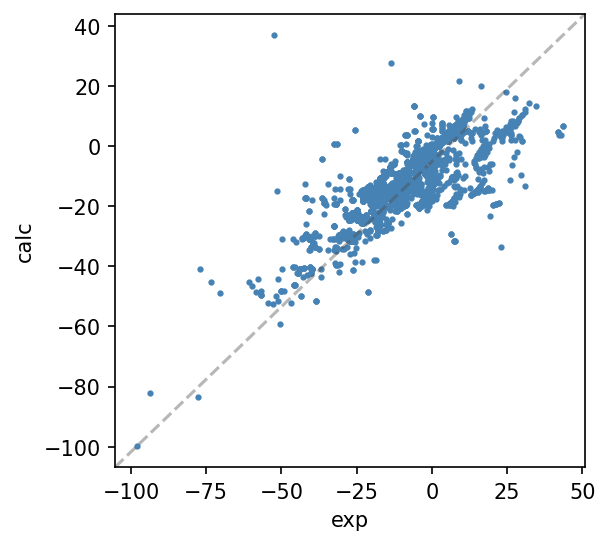

In [12]:
x = y_exp
y = y_calc

"""Jazzy predictions vs. experimental data"""
fig, ax = plt.subplots(dpi=150)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3", alpha=0.4)
points = ax.scatter(x, y, s=4, color='steelblue')
ax.set_aspect('equal', adjustable='box')
# tooltip = plugins.PointHTMLTooltip(points, svgs)
# plugins.connect(fig, tooltip)
plt.xlabel("exp")
plt.ylabel("calc")
plt.show()